In [1]:
import spacy
import pandas as pd
import numpy as np
import nltk

In [5]:
from normalization import normalize_corpus

In [3]:
movie_data =  pd.read_csv('../dataset/movieDescriptionDataSet.tsv', sep='\t')

In [6]:
movie_titles = movie_data['Title'].tolist();
movie_synopses = movie_data['Description'].tolist()
movie_genre = movie_data['Genre'].tolist()

In [16]:
norm_movie_synopses = normalize_corpus(movie_synopses,
                                       lemmatize=True,
                                       only_text_chars=True)




In [17]:
#CREATE FILE WITH THE NORMALIZED CORPUS
norm_movie_synopses_DF = pd.DataFrame(norm_movie_synopses ,columns=['normalized_corpus'])
norm_movie_synopses_DF.to_csv('movieDescriptionDataSetProcessed.tsv', index=False, encoding='utf-8' , sep='\t')

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#TFID VECTORIZER





In [56]:
vectorizer2 = TfidfVectorizer(min_df=0.021, max_df=0.99,ngram_range=(1, 2))
feature_matrix1 = vectorizer2.fit_transform(norm_movie_synopses).astype(float)
print (feature_matrix1.shape) 

(398, 210)


In [57]:
feature_names2 = vectorizer2.get_feature_names()
print (feature_names2[:20])

['across', 'adventure', 'agent', 'alien', 'along', 'america', 'american', 'army', 'around', 'arrive', 'attack', 'attempt', 'away', 'battle', 'beautiful', 'become', 'begin', 'behind', 'believe', 'best']


In [68]:

vectorizer = TfidfVectorizer(max_features=400)
feature_matrix = vectorizer.fit_transform(norm_movie_synopses).astype(float)
print (feature_matrix.shape) 


(398, 400)


In [69]:
feature_names = vectorizer.get_feature_names()
print (feature_names[:400])

['accidentally', 'across', 'action', 'adventure', 'agent', 'aid', 'alien', 'ally', 'along', 'america', 'american', 'another', 'apart', 'ape', 'army', 'around', 'arrive', 'attack', 'attempt', 'away', 'bad', 'band', 'bank', 'base', 'batman', 'battle', 'beautiful', 'become', 'begin', 'behind', 'believe', 'best', 'big', 'black', 'bond', 'book', 'boy', 'break', 'bright', 'bring', 'british', 'brother', 'bruce', 'building', 'buzz', 'caesar', 'call', 'captain', 'care', 'career', 'case', 'catch', 'cause', 'century', 'challenge', 'chance', 'change', 'chaos', 'child', 'christmas', 'city', 'close', 'complete', 'confront', 'conspiracy', 'continue', 'control', 'cop', 'could', 'country', 'course', 'create', 'creature', 'crew', 'crime', 'criminal', 'danger', 'dangerous', 'dark', 'daughter', 'day', 'dead', 'deadly', 'deal', 'death', 'decide', 'desperate', 'despite', 'destroy', 'detective', 'determine', 'die', 'disaster', 'discover', 'discovery', 'dr', 'draw', 'dream', 'earth', 'effort', 'embark', 'emer

In [70]:
from sklearn.cluster import KMeans

In [71]:
def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

In [72]:
num_clusters = 10

In [91]:
distortions = []
K = range(1, 100)
for i in K:
    kmeans = KMeans(n_clusters = i, max_iter=10000)
    kmeans.fit(feature_matrix)
    distortions.append(kmeans.inertia_)

KeyboardInterrupt: 

In [75]:
%matplotlib inline

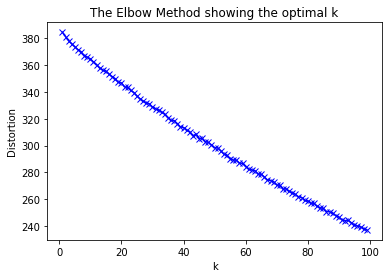

In [76]:
import matplotlib.pyplot as plt

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [92]:
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
movie_data['Cluster'] = clusters

In [93]:
from collections import Counter


In [94]:
c = Counter(clusters)
print (c.items())

dict_items([(1, 76), (3, 33), (2, 48), (7, 41), (8, 43), (4, 26), (6, 38), (5, 39), (9, 33), (0, 21)])


In [82]:
def get_cluster_data(clustering_obj, movie_data, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        movies = movie_data[movie_data['Cluster'] == cluster_num]['Title'].values.tolist()
        genres = movie_data[movie_data['Cluster'] == cluster_num]['Genre'].values.tolist()
        
        cluster_details[cluster_num]['movies'] = movies
        cluster_details[cluster_num]['genres'] = genres
    
    return cluster_details
        
       
    
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print ('Cluster {} details:'.format(cluster_num))
        print ('-'*20)
        print ('Key features:', cluster_details['key_features'])
        print ('Movies in this cluster:')
        print (', '.join(cluster_details['movies']))
        
        print ('Movie genres:')
        print (', '.join(cluster_details['genres']))

        
        print ('='*40)

cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=5)         

print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: ['time', 'wife', 'give', 'child', 'break']
Movies in this cluster:
Ant-Man and the Wasp, Incredibles 2, A Star Is Born, Mowgli: Legend of the Jungle, National Lampoon's Christmas Vacation, Thor: Ragnarok, Aan Devathai, Female War: A Nasty Deal, Pulp Fiction, The Imitation Game, Gone Girl, The Purge, Cinderella, The Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The Incredibles, The Santa Clause 2, Despicable Me, The Shawshank Redemption, Sorry to Bother You, One Flew Over the Cuckoo's Nest, The Fifth Element, Breakthrough, Rocky, Hitchcock, Monsters, Inc., Chappie, Gremlins, Back to the Future, The Twilight Saga: Breaking Dawn - Part 2, Sk8 Dawg, Time Freak, First Reformed, Kung Fu Panda, Red Istanbul
Movie genres:
ACTION,ADVENTURE,SCIENCE FICTION,COMEDY,FAMILY, ACTION,ADVENTURE,ANIMATION,FAMILY, DRAMA,MUSIC,ROMANCE, ADVENTURE,DRAMA, COMEDY, ACTION,ADVENTURE,COMEDY,FANTASY,SCIENCE FICTION, DRAMA,FAMILY, DRAMA,ROMANCE, T

Aquaman, Mortal Engines, Avengers: Infinity War, The Grinch, Alpha, The Christmas Chronicles, How the Grinch Stole Christmas, Avengers: Age of Ultron, Elf, The Lord of the Rings: The Fellowship of the Ring, A Christmas Carol, Iron Man, Rent-an-Elf, The Lord of the Rings: The Return of the King, The Martian, Teenage Mutant Ninja Turtles, Toy Story, Maleficent, Home Alone 2: Lost in New York, Ice Age, It's a Wonderful Life, The Nightmare Before Christmas, Adrift, My Neighbor Totoro, X-Men: Days of Future Past, War for the Planet of the Apes, Disobedience, The Muppet Christmas Carol, Rogue One: A Star Wars Story, Rudolph the Red-Nosed Reindeer, A Christmas Story, The Hunger Games: Catching Fire, Finding Nemo, Toy Story 3, Toy Story 2, A Christmas Prince: The Royal Wedding, Monty Python and the Holy Grail
Movie genres:
ACTION,FANTASY,SCIENCE FICTION,ADVENTURE,ROMANCE, SCIENCE FICTION, ADVENTURE,ACTION,FANTASY, ANIMATION,FAMILY,COMEDY,FANTASY, ADVENTURE,DRAMA, COMEDY,ADVENTURE,FAMILY,FANTAS

DRAMA,MUSIC, ADVENTURE,COMEDY,FANTASY,HORROR,FAMILY, ACTION,ADVENTURE,SCIENCE FICTION, ACTION,ANIMATION,SCIENCE FICTION, ADVENTURE,FANTASY,FAMILY, ACTION, THRILLER,ACTION,CRIME, ADVENTURE,FANTASY,FAMILY, ACTION,ADVENTURE,FANTASY, ACTION,THRILLER,SCIENCE FICTION,MYSTERY,ADVENTURE, ACTION,ADVENTURE,SCIENCE FICTION,FANTASY, ACTION,ADVENTURE,FANTASY, ADVENTURE,FANTASY,FAMILY, FAMILY,FANTASY,ADVENTURE, ACTION,ADVENTURE,FANTASY, DRAMA, ADVENTURE,COMEDY,FANTASY,FAMILY, COMEDY,DRAMA,ROMANCE, ACTION,ADVENTURE, ADVENTURE,FANTASY,FAMILY, ADVENTURE,FANTASY,FAMILY,MYSTERY, ACTION,SCIENCE FICTION, HORROR,THRILLER, ACTION,COMEDY,THRILLER, ADVENTURE,FANTASY,FAMILY, HORROR,ACTION,DRAMA,FANTASY,WAR, ACTION,ADVENTURE,COMEDY,FANTASY, ADVENTURE,FANTASY,FAMILY, DRAMA,CRIME,THRILLER,HORROR, HORROR,FANTASY,THRILLER
Cluster 8 details:
--------------------
Key features: ['school', 'high', 'love', 'life', 'friend']
Movies in this cluster:
Venom, A Simple Favor, The Equalizer 2, Night School, Star Wars: The Last 

In [84]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties

def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16,8)):
    # generate random color for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters    
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", 
              random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': movie_data['Cluster'].values.tolist(),
                                       'title': movie_data['Title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.ix[index]['x'], 
                cluster_plot_frame.ix[index]['y'], 
                cluster_plot_frame.ix[index]['title'], size=8)  
    # show the plot           
    plt.show() 

C:\Users\V622980\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:59: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


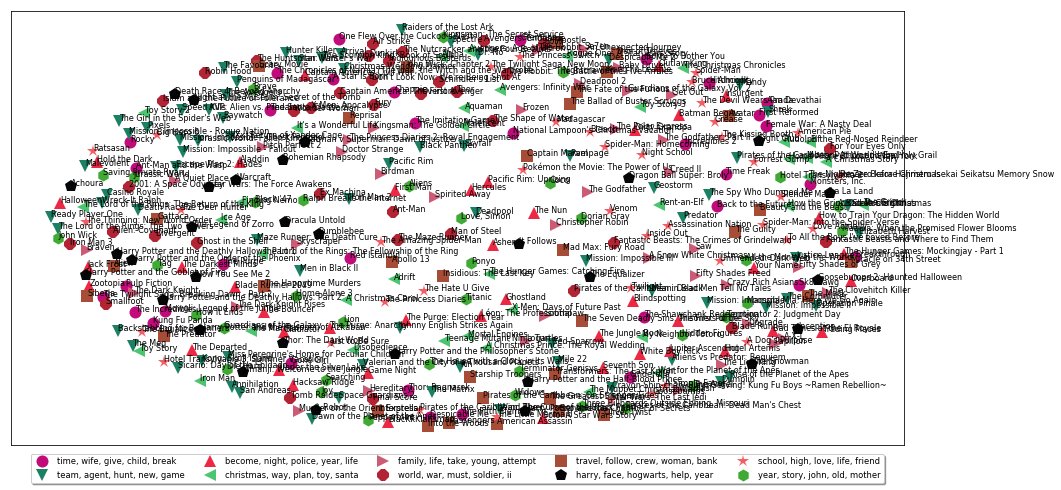

In [85]:
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8))  

In [95]:
from sklearn.cluster import AffinityPropagation
              
def affinity_propagation(feature_matrix):
    
    sim = feature_matrix * feature_matrix.T
    sim = sim.todense()
    ap = AffinityPropagation()
    ap.fit(sim)
    clusters = ap.labels_          
    return ap, clusters

In [96]:
ap_obj, clusters = affinity_propagation(feature_matrix=feature_matrix)
movie_data['Cluster'] = clusters

In [100]:
c = Counter(clusters)   
print (c.items()  )


dict_items([(0, 8), (54, 8), (11, 7), (24, 7), (33, 9), (1, 6), (2, 7), (15, 8), (3, 9), (43, 6), (4, 10), (35, 7), (58, 5), (5, 6), (8, 6), (12, 6), (32, 7), (37, 6), (6, 11), (29, 6), (47, 6), (55, 8), (18, 7), (49, 4), (21, 5), (56, 8), (10, 6), (53, 5), (40, 8), (50, 7), (36, 6), (28, 6), (38, 10), (27, 7), (51, 4), (45, 9), (7, 5), (13, 8), (26, 6), (31, 6), (17, 10), (9, 5), (20, 8), (46, 8), (25, 7), (48, 7), (19, 5), (22, 5), (23, 6), (41, 6), (14, 4), (30, 5), (44, 7), (34, 10), (39, 5), (16, 9), (52, 6), (42, 6), (57, 3)])


In [103]:
total_clusters = len(c)
print ('Total Clusters:', total_clusters)

Total Clusters: 59


In [104]:
cluster_data =  get_cluster_data(clustering_obj=ap_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=total_clusters,
                                 topn_features=5)         

print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: ['accidentally', 'enemy', 'dead', 'resistance', 'old']
Movies in this cluster:
Venom, Fifty Shades Freed, A Dog's Purpose, The Little Mermaid, Rampage, The Polar Express, Pirates of the Caribbean: At World's End, Siberia
Movie genres:
SCIENCE FICTION, DRAMA,ROMANCE, COMEDY,DRAMA,FAMILY,FANTASY, ADVENTURE,FANTASY,ROMANCE,DRAMA, ACTION,ADVENTURE,SCIENCE FICTION,FANTASY, ADVENTURE,ANIMATION,FAMILY,FANTASY, ADVENTURE,FANTASY,ACTION, CRIME,ROMANCE,THRILLER
Cluster 1 details:
--------------------
Key features: ['alien', 'brother', 'aid', 'create', 'survival']
Movies in this cluster:
Bohemian Rhapsody, Kung Fu League, Deadpool 2, Die Hard, Big Hero 6, Scary Movie
Movie genres:
DRAMA,MUSIC, ACTION,COMEDY, ACTION,COMEDY,ADVENTURE, ACTION,THRILLER, ADVENTURE,FAMILY,ANIMATION,ACTION,COMEDY, COMEDY
Cluster 2 details:
--------------------
Key features: ['ally', 'mount', 'mind', 'power', 'question']
Movies in this cluster:
Robin Hood, Split, La L

Female War: A Nasty Deal, The Hunger Games: Mockingjay - Part 1, Gone Girl, The Greatest Showman, Avatar, Overboard, Joy, White Boy Rick, Kung Fu Panda
Movie genres:
DRAMA,ROMANCE, SCIENCE FICTION,ADVENTURE,THRILLER, MYSTERY,THRILLER,DRAMA, DRAMA, ACTION,ADVENTURE,FANTASY,SCIENCE FICTION, ROMANCE,COMEDY, DRAMA,COMEDY, DRAMA,CRIME, ADVENTURE,ANIMATION,FAMILY,COMEDY
Cluster 17 details:
--------------------
Key features: ['face', 'ii', 'destroy', 'catch', 'ex']
Movies in this cluster:
Just to Be Sure, The First Purge, Tomb Raider, Bad Times at the El Royale, Mamma Mia! Here We Go Again, A Snow White Christmas, Cinderella, My Neighbor Totoro, Jack Frost, Ponyo
Movie genres:
DRAMA,COMEDY, ACTION,SCIENCE FICTION,THRILLER,HORROR, ACTION,ADVENTURE,FANTASY, THRILLER,CRIME,MYSTERY, COMEDY,ROMANCE, DRAMA,ROMANCE,TV MOVIE, ROMANCE,FANTASY,FAMILY,DRAMA, FANTASY,ANIMATION,FAMILY, COMEDY,FAMILY,DRAMA,FANTASY, ANIMATION,FAMILY
Cluster 18 details:
--------------------
Key features: ['figure', 'deal', '

Key features: ['lord', 'must', 'inside', 'resistance', 'agent']
Movies in this cluster:
The Predator, Smallfoot, Transformers: The Last Knight, The Matrix, Jupiter Ascending, Pacific Rim: Uprising, Captain Marvel, Sorry to Bother You, The Fifth Element
Movie genres:
SCIENCE FICTION,ACTION,THRILLER,ADVENTURE, COMEDY,ANIMATION,FAMILY,ADVENTURE,FANTASY, ACTION,SCIENCE FICTION,THRILLER,ADVENTURE, ACTION,SCIENCE FICTION, SCIENCE FICTION,FANTASY,ACTION,ADVENTURE, ACTION,FANTASY,SCIENCE FICTION,ADVENTURE, ACTION,ADVENTURE,SCIENCE FICTION, FANTASY,SCIENCE FICTION,COMEDY, ADVENTURE,FANTASY,ACTION,THRILLER,SCIENCE FICTION
Cluster 34 details:
--------------------
Key features: ['may', 'epic', 'ethan', 'hold', 'program']
Movies in this cluster:
Iron Man, Captain America: Civil War, Doctor Strange, Insurgent, xXx: Return of Xander Cage, Mad Max: Fury Road, Warcraft, Iron Man 2, Now You See Me 2, Arrival
Movie genres:
ACTION,SCIENCE FICTION,ADVENTURE, ADVENTURE,ACTION,SCIENCE FICTION, ACTION,ADVENTU

ACTION,THRILLER,ADVENTURE,CRIME, DRAMA,ACTION,CRIME,THRILLER, THRILLER,SCIENCE FICTION,ACTION, CRIME,COMEDY,ACTION,ADVENTURE, COMEDY, CRIME,DRAMA,FAMILY, ANIMATION,FAMILY,COMEDY,ADVENTURE,FANTASY,ROMANCE
Cluster 49 details:
--------------------
Key features: ['stark', 'still', 'survive', 'beautiful', 'like']
Movies in this cluster:
Mowgli: Legend of the Jungle, Monsters, Inc., Chappie, The Twilight Saga: Breaking Dawn - Part 2
Movie genres:
ADVENTURE,DRAMA, ANIMATION,COMEDY,FAMILY, CRIME,ACTION,SCIENCE FICTION, ADVENTURE,FANTASY,DRAMA,ROMANCE
Cluster 50 details:
--------------------
Key features: ['state', 'head', 'late', 'son', 'hero']
Movies in this cluster:
Night School, Assassination Nation, Dirty Grandpa, The Commuter, Papillon, Bleach, Your Name.
Movie genres:
COMEDY, THRILLER,COMEDY,ACTION,DRAMA, COMEDY, ACTION,THRILLER, DRAMA,ADVENTURE, ACTION,FANTASY,ADVENTURE, ROMANCE,ANIMATION,DRAMA
Cluster 51 details:
--------------------
Key features: ['struggle', 'thief', 'effort', 'terro

C:\Users\V622980\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:59: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


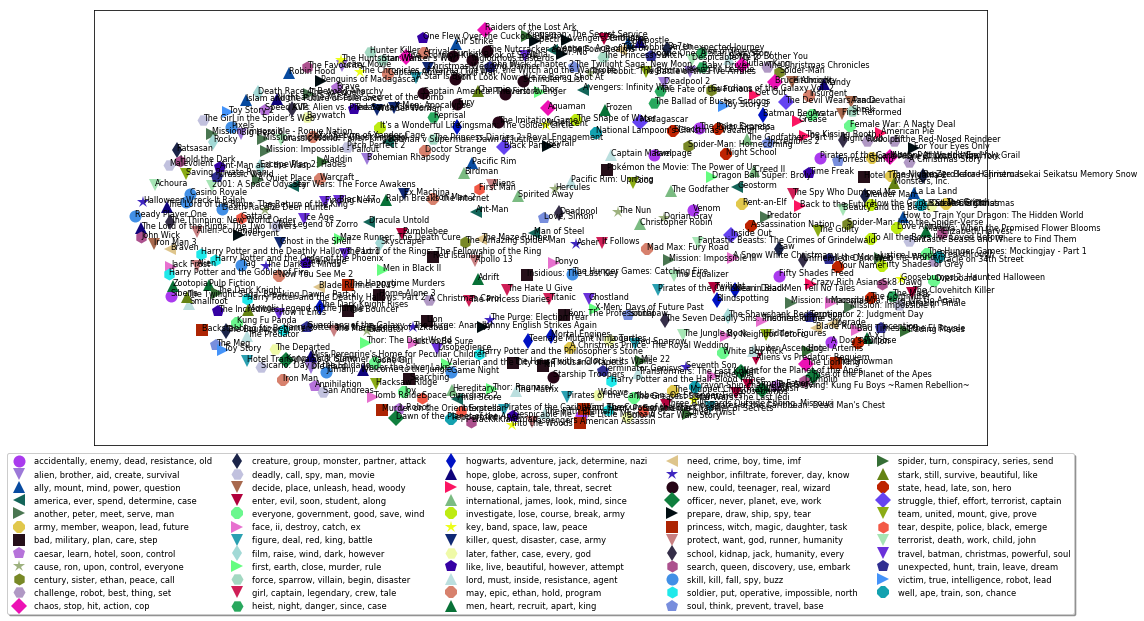

In [105]:
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8)) 

In [106]:
from scipy.cluster.hierarchy import ward, dendrogram

def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix


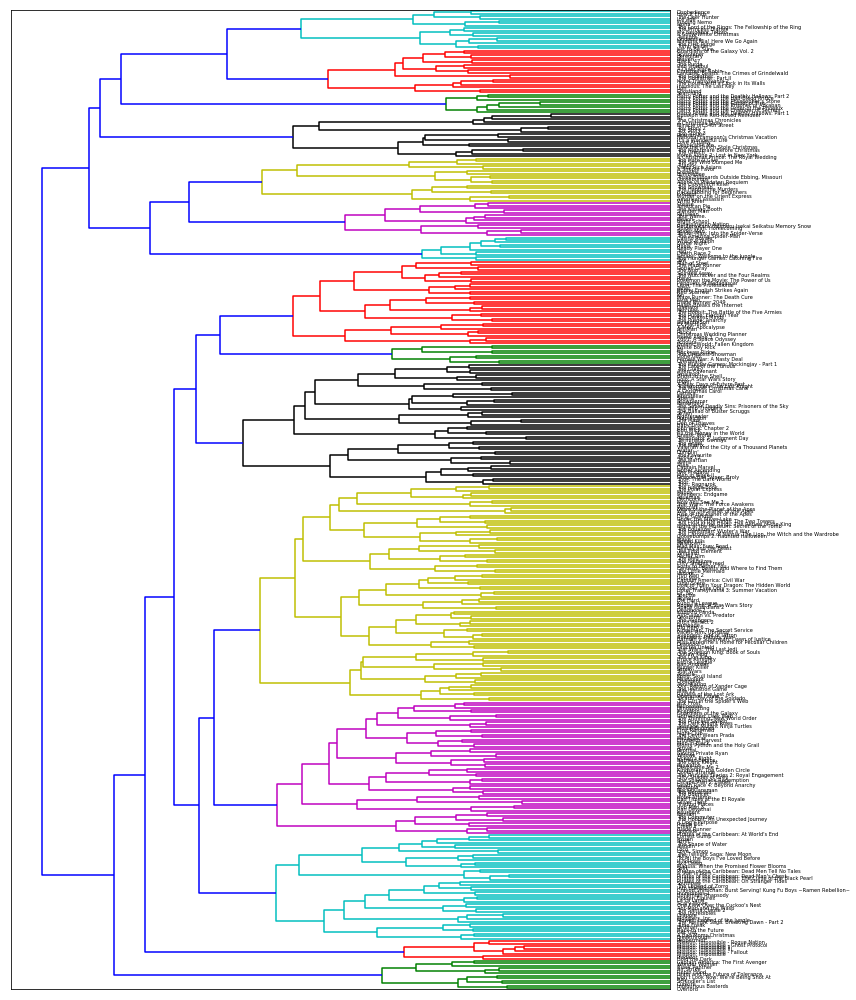

In [109]:
def plot_hierarchical_clusters(linkage_matrix, movie_data, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    movie_titles = movie_data['Title'].values.tolist()
    # plot dendrogram
    ax = dendrogram(linkage_matrix, orientation="left", labels=movie_titles)
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('ward_hierachical_clusters.png', dpi=400)

# build ward's linkage matrix    
linkage_matrix = ward_hierarchical_clustering(feature_matrix)
# plot the dendrogram
plot_hierarchical_clusters(linkage_matrix=linkage_matrix,
                           movie_data=movie_data,
                           figure_size=(12,14))